In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# Load customer data
customers = pd.read_csv('Customers.csv', parse_dates=['SignupDate'])
current_date = pd.to_datetime('2024-12-31')  # Assuming analysis date
customers['Tenure'] = (current_date - customers['SignupDate']).dt.days

In [3]:
# Load transaction data
transactions = pd.read_csv('Transactions.csv', parse_dates=['TransactionDate'])

# Aggregate transaction metrics per customer
transactions_agg = transactions.groupby('CustomerID').agg(
    TotalTransactions=('TransactionID', 'count'),
    TotalSpent=('TotalValue', 'sum'),
    LastTransactionDate=('TransactionDate', 'max')
).reset_index()

# Calculate recency (days since last transaction)
transactions_agg['Recency'] = (current_date - transactions_agg['LastTransactionDate']).dt.days
transactions_agg.drop('LastTransactionDate', axis=1, inplace=True)

In [4]:
# Merge customer and transaction data
data = pd.merge(customers, transactions_agg, on='CustomerID', how='inner')

# Drop irrelevant columns
data_clean = data.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1)

# One-hot encode 'Region'
data_clean = pd.get_dummies(data_clean, columns=['Region'], drop_first=True)

In [5]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_clean)

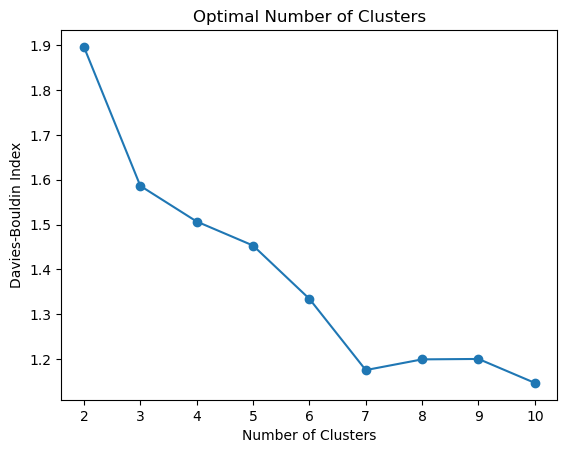

In [6]:
# Suppress the warning
os.environ["OMP_NUM_THREADS"] = "1"
warnings.filterwarnings("ignore", message=".*KMeans is known to have a memory leak.*")
db_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, algorithm='lloyd')
    labels = kmeans.fit_predict(scaled_data)
    db_scores.append(davies_bouldin_score(scaled_data, labels))

# Plot DB Index
plt.plot(range(2, 11), db_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Optimal Number of Clusters')
plt.show()

In [7]:
# Optimal clusters = 3 (lowest DB Index)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

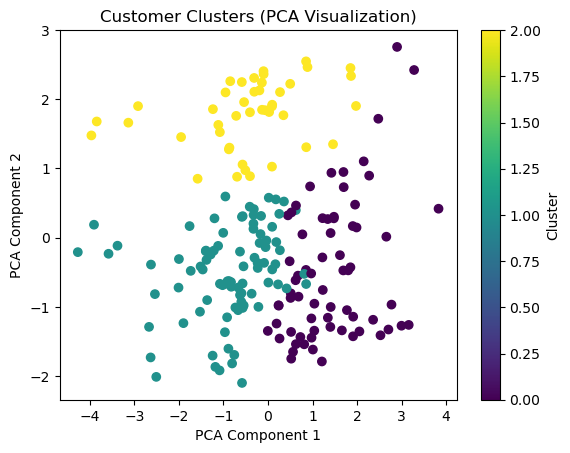

In [8]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Clusters (PCA Visualization)')
plt.colorbar(label='Cluster')
plt.show()

In [9]:
data_clean['Cluster'] = clusters
cluster_summary = data_clean.groupby('Cluster').mean()
print(cluster_summary)

             Tenure  TotalTransactions   TotalSpent    Recency  Region_Europe  \
Cluster                                                                         
0        579.382353           6.808824  5052.936912  48.955882       0.073529   
1        549.761364           3.693182  2441.680114  90.477273       0.511364   
2        416.720930           4.930233  3058.790698  91.348837       0.000000   

         Region_North America  Region_South America  
Cluster                                              
0                    0.044118              0.617647  
1                    0.000000              0.193182  
2                    1.000000              0.000000  
